### 專案名稱: 第四屆機器學習百日馬拉松
### 功能描述: 第81天作業
### 版權所有: Dunk  
### 程式撰寫: Dunk  
### 撰寫日期：2020/06/12
### 改版日期:  
### 改版備註:

## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

### ANS:

In [11]:
import os
import keras
import itertools
from keras.regularizers import l1, l2, l1_l2

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [12]:
train, test = keras.datasets.cifar10.load_data()

In [13]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [14]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [15]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

####  l1

In [16]:
def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [17]:
results = {}
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [====

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 224us/step - loss: 2.0317 - accuracy: 0.2743 - val_loss: 1.8699 - val_accuracy: 0.3453
Epoch 2/10
50000/50000 [==============================] - 11s 224us/step - loss: 1.8047 - accuracy: 0.3661 - val_loss: 1.7599 - val_accuracy: 0.3782
Epoch 3/10
50000/50000 [==============================] - 11s 226us/step - loss: 1.7217 - accuracy: 0.3952 - val_loss: 1.6994 - val_accuracy: 0.4023
Epoch 4/10
50000/50000 [==============================] - 11s 229us/step - loss: 1.6643 - accuracy: 0.4188 - val_loss: 1.6571 - val_accuracy: 0.4158
Epoch 5/10
50000/50000 [==============================] - 11s 229us/step - loss: 1.6161 - accuracy: 0.4355 - val_loss: 1.6162 - val_accuracy: 0.4294
Epoch 6/10
50000/50000 [==============================] - 11s 225us/step - loss: 1.5747 - accuracy: 0.4502 - val_loss: 1.5678 - val_accuracy: 0.4461
Epoch 7/10
50000/50000 [==============================] 

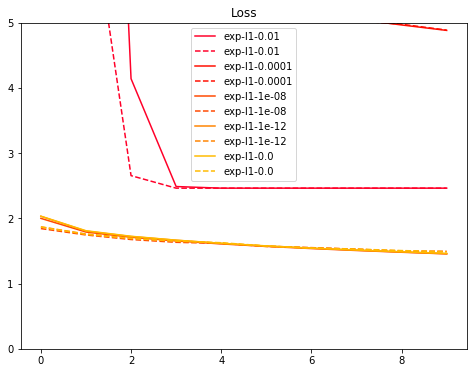

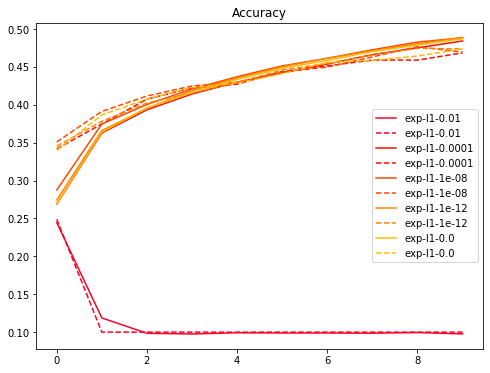

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

#### l1_l2

In [19]:
def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [20]:
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp_l1_l2(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/500

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 13s 270us/step - loss: 198.6375 - accuracy: 0.2463 - val_loss: 41.1116 - val_accuracy: 0.2338
Epoch 2/10
50000/50000 [==============================] - 13s 254us/step - loss: 19.1093 - accuracy: 0.1175 - val_loss: 7.2823 - val_accuracy: 0.1000
Epoch 3/10
50000/50000 [==============================] - 12s 250us/step - loss: 4.1064 - accuracy: 0.0982 - val_loss: 2.6480 - val_accuracy: 0.1000
Epoch 4/10
50000/50000 [==============================] - 12s 247us/step - loss: 2.4865 - accuracy: 0.0970 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 5/10
50000/50000 [==============================] - 12s 245us/step - loss: 2.4626 - accuracy: 0.0986 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 6/10
50000/50000 [==============================] - 12s 239us/step - loss: 2.4626 - accuracy: 0.0974 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 7/10
50000/50000 [============================

50000/50000 [==============================] - 12s 245us/step - loss: 5.7041 - accuracy: 0.3908 - val_loss: 5.6379 - val_accuracy: 0.4048
Epoch 4/10
50000/50000 [==============================] - 12s 243us/step - loss: 5.5797 - accuracy: 0.4122 - val_loss: 5.5235 - val_accuracy: 0.4176
Epoch 5/10
50000/50000 [==============================] - 12s 243us/step - loss: 5.4665 - accuracy: 0.4260 - val_loss: 5.4185 - val_accuracy: 0.4275
Epoch 6/10
50000/50000 [==============================] - 12s 244us/step - loss: 5.3595 - accuracy: 0.4398 - val_loss: 5.3124 - val_accuracy: 0.4447
Epoch 7/10
50000/50000 [==============================] - 12s 247us/step - loss: 5.2593 - accuracy: 0.4522 - val_loss: 5.2249 - val_accuracy: 0.4490
Epoch 8/10
50000/50000 [==============================] - 12s 244us/step - loss: 5.1622 - accuracy: 0.4624 - val_loss: 5.1352 - val_accuracy: 0.4578
Epoch 9/10
50000/50000 [==============================] - 12s 246us/step - loss: 5.0689 - accuracy: 0.4714 - val_loss

50000/50000 [==============================] - 11s 226us/step - loss: 5.3434 - accuracy: 0.4334 - val_loss: 5.3030 - val_accuracy: 0.4361
Epoch 6/10
50000/50000 [==============================] - 11s 227us/step - loss: 5.2423 - accuracy: 0.4452 - val_loss: 5.2246 - val_accuracy: 0.4369
Epoch 7/10
50000/50000 [==============================] - 12s 232us/step - loss: 5.1489 - accuracy: 0.4566 - val_loss: 5.1181 - val_accuracy: 0.4533
Epoch 8/10
50000/50000 [==============================] - 11s 221us/step - loss: 5.0572 - accuracy: 0.4672 - val_loss: 5.0290 - val_accuracy: 0.4668
Epoch 9/10
50000/50000 [==============================] - 11s 229us/step - loss: 4.9699 - accuracy: 0.4758 - val_loss: 4.9657 - val_accuracy: 0.4582
Epoch 10/10
50000/50000 [==============================] - 12s 232us/step - loss: 4.8849 - accuracy: 0.4854 - val_loss: 4.9065 - val_accuracy: 0.4576
Experiment with L1 = 0.000000, L2 = 0.010000
Model: "model_1"
______________________________________________________

50000/50000 [==============================] - 11s 229us/step - loss: 1.5327 - accuracy: 0.4639 - val_loss: 1.5353 - val_accuracy: 0.4601
Epoch 8/10
50000/50000 [==============================] - 11s 230us/step - loss: 1.5023 - accuracy: 0.4729 - val_loss: 1.5197 - val_accuracy: 0.4647
Epoch 9/10
50000/50000 [==============================] - 11s 229us/step - loss: 1.4751 - accuracy: 0.4833 - val_loss: 1.4966 - val_accuracy: 0.4675
Epoch 10/10
50000/50000 [==============================] - 11s 229us/step - loss: 1.4517 - accuracy: 0.4899 - val_loss: 1.4783 - val_accuracy: 0.4744
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
______________________

50000/50000 [==============================] - 12s 243us/step - loss: 5.4583 - accuracy: 0.4349 - val_loss: 5.1705 - val_accuracy: 0.4322
Epoch 10/10
50000/50000 [==============================] - 12s 244us/step - loss: 4.9152 - accuracy: 0.4380 - val_loss: 4.6783 - val_accuracy: 0.4321
Experiment with L1 = 0.000000, L2 = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 227us/step - loss: 2.0092 - accuracy: 0.2807 - val_loss: 1.8557 - val_accuracy: 0.3504
Epoch 2/10
50000/50000 [==============================] - 11s 230us/step - loss: 1.7935 - accuracy: 0.3710 - val_loss: 1.7401 - val_accuracy: 0.3943
Epoch 3/10
50000/50000 [==============================] - 12s 234us/step - loss: 1.7107 - accuracy: 0.3998 - val_loss: 1.6822 - val_accuracy: 0.4106
Epoch 4/10
50000/50000 [==============================] - 12s 239us/step - loss: 1.6536 - accuracy: 0.4203 - val_loss: 1.6335 - val_accuracy: 0.4267
Epoch 5/10
50000/50000 [==============================] - 12s 242us/step - loss: 1.6094 - accuracy: 0.4354 - val_loss: 1.5973 - val_accuracy: 0.4396
Epoch 6/10
50000/50000 [==============================] - 12s 239us/step - loss: 1.5717 - accuracy: 0.4485 - val_loss: 1.5730 - val_accuracy: 0.4404
Epoch 7/10
50000/50000 [==============================] 

50000/50000 [==============================] - 11s 225us/step - loss: 1.7187 - accuracy: 0.3995 - val_loss: 1.6830 - val_accuracy: 0.4113
Epoch 4/10
50000/50000 [==============================] - 11s 226us/step - loss: 1.6602 - accuracy: 0.4212 - val_loss: 1.6340 - val_accuracy: 0.4291
Epoch 5/10
50000/50000 [==============================] - 11s 226us/step - loss: 1.6150 - accuracy: 0.4355 - val_loss: 1.6071 - val_accuracy: 0.4341
Epoch 6/10
50000/50000 [==============================] - 11s 227us/step - loss: 1.5759 - accuracy: 0.4497 - val_loss: 1.5719 - val_accuracy: 0.4529
Epoch 7/10
50000/50000 [==============================] - 11s 226us/step - loss: 1.5436 - accuracy: 0.4572 - val_loss: 1.5544 - val_accuracy: 0.4543
Epoch 8/10
50000/50000 [==============================] - 11s 223us/step - loss: 1.5157 - accuracy: 0.4698 - val_loss: 1.5191 - val_accuracy: 0.4630
Epoch 9/10
50000/50000 [==============================] - 11s 220us/step - loss: 1.4884 - accuracy: 0.4786 - val_loss

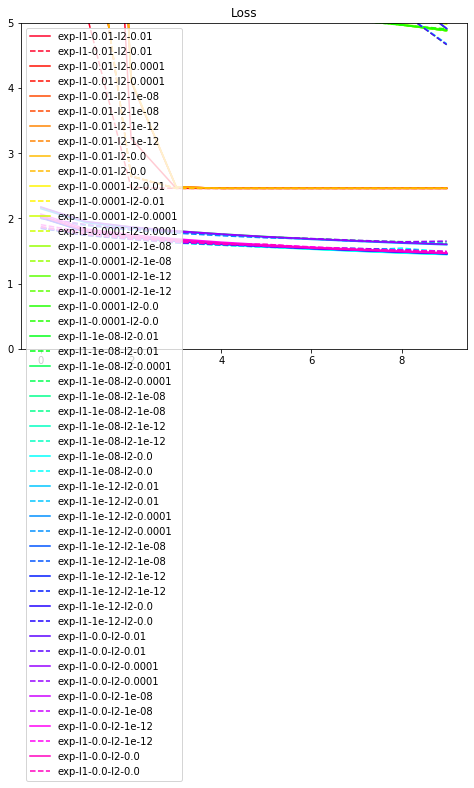

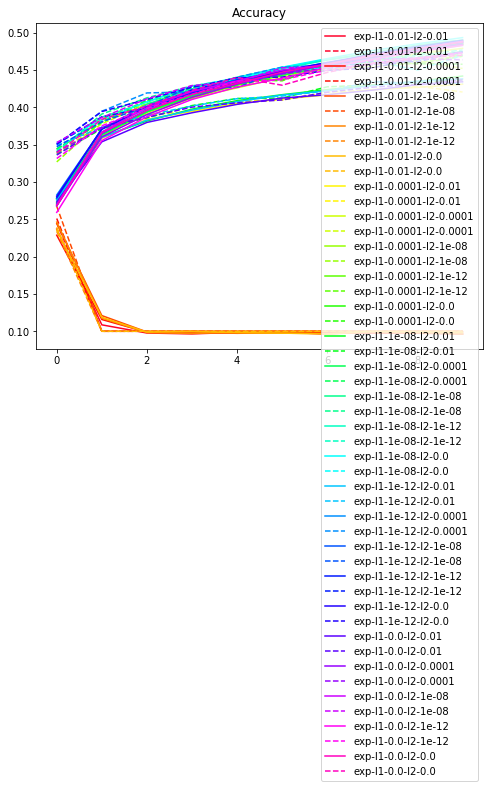

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()